In [1]:
import matplotlib.pyplot as plt
import numpy as cp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer

X, y = load_breast_cancer(return_X_y=True)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = cp.asarray(X_train.T)
y_train = cp.asarray(y_train.reshape(1, -1))

X_test = cp.asarray(X_test.T)
y_test = cp.asarray(y_test.reshape(1, -1))
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((30, 455), (1, 455), (30, 114), (1, 114))

# 1. MLP in Numpy ( no CUDA )

In [2]:
class MLP:

  #==============> MLPBLOCK <====================
  class MLPBlock:
    def __init__(self,
                 input_dims:int,
                 output_dims:int,
                 final: bool,
                 lr:float = 0.01
                 ) -> None:
      self.w = cp.random.rand(output_dims, input_dims)
      self.b = cp.random.rand(output_dims, 1)
      self.final = final
      self.cache = None
      self.lr = lr

    def forward(self, x):
      """
      inputs:
        x: (input_dims, m)
      outputs:
        a: (output_dims, m)
      """
      z = cp.dot(self.w, x) + self.b
      if not self.final:
        a = self.tanh(z)
      else:
        a = self.sigmoid(z)
      self.__update_cache(x, z, a)
      return a

    def backward(self, da):
      """
      inputs:
        da: (output_dims, m)
      outputs:
        dz: (input_dims, m)
        dw: (output_dims, input_dims)
        db: (output_dims, 1)
      """
      a = self.cache["a"]
      z = self.cache["z"]
      x = self.cache["x"]

      if not self.final:
        dz = (1-a**2)*da
      else:
        #da is y in this case
        dz = a - da

      dw = cp.dot(dz, x.T)
      db = cp.sum(dz, axis=1, keepdims=True)
      dx = cp.dot(self.w.T, dz)

      self.w -= dw * self.lr
      self.b -= db * self.lr
      return dx

    def tanh(self, x):
      return (cp.exp(x) - cp.exp(-x)) / (cp.exp(x) + cp.exp(-x))

    def sigmoid(self, x):
      return 1 / (1 + cp.exp(-x))

    def __update_cache(self, x, z, a):
      self.cache = {
          "x": x,
          "z": z,
          "a": a
      }

  #===========> END of MLPBlock <===================

  def __init__(self,
               input_dim: int = 3,
               ):
    self.layers = [
      self.MLPBlock(input_dim, 64, False),
      self.MLPBlock(64, 8, False),
      self.MLPBlock(8, 1, True),
    ]

  def forward(self, x):
    for layer in self.layers:
      x = layer.forward(x)
    return x

  def backward(self, da):
    for layer in reversed(self.layers):
      da = layer.backward(da)

In [3]:
def bce_loss(y, y_hat):
  eps = 1e-8
  return cp.mean(-(y*cp.log(y_hat+eps) + (1-y)*cp.log(1-y_hat+eps)))

In [8]:
epochs = 20
model = MLP(30)

In [ ]:
yhat = model.forward(X_train)
print(y_train.shape, yhat.shape)
print("BCE: ", bce_loss(y_train, yhat))

(1, 455) (1, 455)
BCE:  5.140342481608193


In [9]:
%%time
history = {
    "train": [],
    "val": []
}
for epoch in range(epochs):
  y_hat = model.forward(X_train)
  train_loss = bce_loss(y_train, y_hat)
  model.backward(y_train)

  val_loss = bce_loss(y_test, model.forward(X_test))
  print(f"Epoch {epoch+1:2d}/{epochs}   train_loss: {train_loss:.5f}   val_loss:{val_loss:.5f}")
  history["train"].append(train_loss)
  history["val"].append(val_loss)

Epoch  1/20   train_loss: 3.13294   val_loss:2.53671
Epoch  2/20   train_loss: 2.12249   val_loss:2.41886
Epoch  3/20   train_loss: 1.75538   val_loss:2.32833
Epoch  4/20   train_loss: 1.57990   val_loss:2.06939
Epoch  5/20   train_loss: 1.37482   val_loss:1.67695
Epoch  6/20   train_loss: 1.09598   val_loss:1.24711
Epoch  7/20   train_loss: 0.79827   val_loss:0.82443
Epoch  8/20   train_loss: 0.50896   val_loss:0.57493
Epoch  9/20   train_loss: 0.38922   val_loss:0.65216
Epoch 10/20   train_loss: 0.40512   val_loss:0.52737
Epoch 11/20   train_loss: 0.38808   val_loss:0.72417
Epoch 12/20   train_loss: 0.45946   val_loss:0.46699
Epoch 13/20   train_loss: 0.33247   val_loss:0.54127
Epoch 14/20   train_loss: 0.34823   val_loss:0.43851
Epoch 15/20   train_loss: 0.34633   val_loss:0.67411
Epoch 16/20   train_loss: 0.44002   val_loss:0.40392
Epoch 17/20   train_loss: 0.29989   val_loss:0.47262
Epoch 18/20   train_loss: 0.31624   val_loss:0.40439
Epoch 19/20   train_loss: 0.33273   val_loss:0

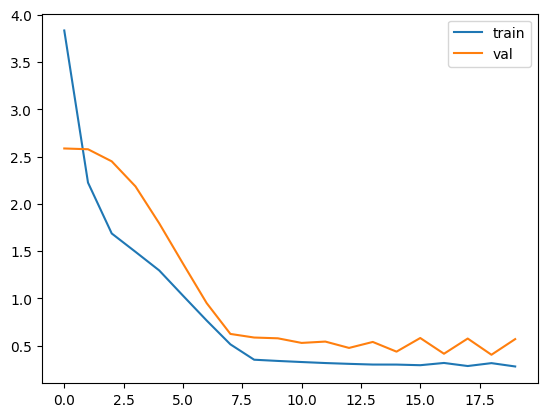

In [7]:
plt.plot(history["train"], label="train")
plt.plot(history["val"], label="val")
plt.legend()
plt.show()

# 2. MLP in CuPy with CUDA

In [1]:
import cupy as cp
import numpy as np

x = np.random.rand(1000000, 5)
y = cp.array(x)

### 1) tanh



In [2]:
tanh_kernel = cp.RawKernel(r'''
extern "C" __global__
void tanh_forward(const float *x, float *out, int n){
  int idx = threadIdx.x + blockIdx.x * blockDim.x;
  if (idx<n) {
    float e_pos = expf(x[idx]);
    float e_neg = expf(-x[idx]);
    out[idx] = (e_pos - e_neg) / (e_pos + e_neg);
  }
}
''', 'tanh_forward')

def tanh_cuda(x):
  x = x.astype(cp.float32)
  out = cp.empty_like(x)
  n = x.size
  threads_per_block = 256
  blocks = (n + threads_per_block - 1) // threads_per_block
  tanh_kernel(
      (blocks,),
      (threads_per_block,),
      (x.ravel(), out.ravel(), n)
  )
  return cp.reshape(out, x.shape)

In [10]:
%%time
xout = np.tanh(x)

CPU times: user 255 ms, sys: 13.5 ms, total: 269 ms
Wall time: 407 ms


In [11]:
%%time
yout = tanh_cuda(y)

CPU times: user 521 µs, sys: 1.07 ms, total: 1.59 ms
Wall time: 5.94 ms


In [12]:
xout[:3], yout[:3]

(array([[0.66203766, 0.63575013, 0.52732667, 0.39785942, 0.13267704],
        [0.63923872, 0.00719125, 0.18228696, 0.18736066, 0.74268513],
        [0.20369649, 0.40658249, 0.37134865, 0.11375123, 0.42054694]]),
 array([[0.6620376 , 0.6357502 , 0.52732664, 0.3978594 , 0.13267705],
        [0.6392387 , 0.00719126, 0.18228693, 0.18736067, 0.74268514],
        [0.20369649, 0.40658247, 0.37134862, 0.1137512 , 0.42054692]],
       dtype=float32))

### 2) sigmoid

In [3]:
sigmoid_kernel = cp.RawKernel(r'''
extern "C" __global__
void sigmoid_forward(const float *x, float* out, int n){
  int idx = threadIdx.x + blockIdx.x * blockDim.x;
  if (idx<n) {
    out[idx] = 1.0f / (1.0f + expf(-x[idx]));
  }
}
''', 'sigmoid_forward')

def sigmoid_cuda(x):
  x = x.astype(cp.float32)
  out = cp.empty_like(x)
  n = x.size
  threads_per_block = 256
  blocks = (n + threads_per_block - 1) // threads_per_block
  sigmoid_kernel(
      (blocks,),
      (threads_per_block,),
      (x.ravel(), out.ravel(), n)
  )
  return cp.reshape(out, x.shape)

In [20]:
%%time
xout = 1/(1 + np.exp(-x))

CPU times: user 47.7 ms, sys: 22 ms, total: 69.7 ms
Wall time: 69 ms


In [21]:
%%time
yout = sigmoid_cuda(y)

CPU times: user 963 µs, sys: 0 ns, total: 963 µs
Wall time: 826 µs


In [22]:
xout[:3], yout[:3]

(array([[0.68921086, 0.67939837, 0.64254672, 0.60374721, 0.53331653],
        [0.68067713, 0.50179784, 0.54595673, 0.54725861, 0.72240865],
        [0.55146361, 0.60623419, 0.59627947, 0.5285304 , 0.61024836]]),
 array([[0.68921083, 0.6793984 , 0.6425467 , 0.6037472 , 0.5333165 ],
        [0.6806772 , 0.50179785, 0.54595673, 0.5472586 , 0.72240865],
        [0.5514636 , 0.6062342 , 0.59627944, 0.52853036, 0.6102483 ]],
       dtype=float32))

### 3) BCE loss


In [4]:
bce_kernel = cp.RawKernel(r'''
    extern "C" __global__
    void bce_loss(const float* y, const float* yhat, float* out, int n){
      extern __shared__ float sdata[];

      int idx = threadIdx.x + blockIdx.x*blockDim.x;
      int tid = threadIdx.x;

      float eps = 1e-7;
      float loss = 0.0f;

      if(idx<n){
        float p = fminf(fmaxf(yhat[idx], eps), 1.0f - eps);
        loss = - (y[idx]*logf(p) + (1.0f-y[idx])*logf(1.0f-p));
      }

      sdata[tid] = loss;
      __syncthreads();

      for(int s=blockDim.x / 2 ; s>0; s>>=1){
        if(tid < s){
          sdata[tid] += sdata[tid+s];
        }
        __syncthreads();
      }

      if(tid==0){
        out[blockIdx.x] = sdata[0];
      }
    }
  ''', 'bce_loss')

def bce_loss_cuda(y, yhat):
  y = y.astype(cp.float32)
  yhat = yhat.astype(cp.float32)
  n = y.size
  threads_per_block = 256
  blocks = (n + threads_per_block - 1) // threads_per_block
  out = cp.empty(blocks, dtype=cp.float32)
  bce_kernel(
      (blocks, ),
      (threads_per_block, ),
      (y, yhat, out, n),
      shared_mem=threads_per_block * 4
  )
  return cp.sum(out)/n

In [31]:
y_cpu = np.random.rand(100000)
y_hat_cpu = 0.7*np.random.rand(100000)

y_gpu = cp.array(y_cpu)
y_hat_gpu = cp.array(y_hat_cpu)

def bce_loss_numpy(y, yhat):
    eps=1e-7
    yhat = np.clip(yhat, eps, 1 - eps)
    loss = - (y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
    return np.mean(loss)

In [34]:
%%time
loss_cpu = bce_loss_numpy(y_cpu, y_hat_cpu)

CPU times: user 2.69 ms, sys: 0 ns, total: 2.69 ms
Wall time: 2.09 ms


In [35]:
%%time
loss_gpu = bce_loss_cuda(y_gpu, y_hat_gpu)

CPU times: user 618 µs, sys: 0 ns, total: 618 µs
Wall time: 626 µs


In [36]:
loss_cpu, loss_gpu

(np.float64(0.9198774290842957), array(0.91987742))

<h1> Simple Neural Network using cuda functions </h1>

In [5]:
class MLP:

  #==============> MLPBLOCK <====================
  class MLPBlock:
    def __init__(self,
                 input_dims:int,
                 output_dims:int,
                 final: bool,
                 lr:float = 0.01
                 ) -> None:
      self.w = cp.random.rand(output_dims, input_dims)
      self.b = cp.random.rand(output_dims, 1)
      self.final = final
      self.cache = None
      self.lr = lr

    def forward(self, x):
      """
      inputs:
        x: (input_dims, m)
      outputs:
        a: (output_dims, m)
      """
      z = cp.dot(self.w, x) + self.b
      if not self.final:
        a = tanh_cuda(z)
      else:
        a = sigmoid_cuda(z)
      self.__update_cache(x, z, a)
      return a

    def backward(self, da):
      """
      inputs:
        da: (output_dims, m)
      outputs:
        dz: (input_dims, m)
        dw: (output_dims, input_dims)
        db: (output_dims, 1)
      """
      a = self.cache["a"]
      z = self.cache["z"]
      x = self.cache["x"]

      if not self.final:
        dz = (1-a**2)*da
      else:
        #da is y in this case
        dz = a - da

      dw = cp.dot(dz, x.T)
      db = cp.sum(dz, axis=1, keepdims=True)
      dx = cp.dot(self.w.T, dz)

      self.w -= dw * self.lr
      self.b -= db * self.lr
      return dx

    def __update_cache(self, x, z, a):
      self.cache = {
          "x": x,
          "z": z,
          "a": a
      }

  #===========> END of MLPBlock <===================

  def __init__(self,
               input_dim: int = 3,
               ):
    self.layers = [
      self.MLPBlock(input_dim, 64, False),
      self.MLPBlock(64, 8, False),
      self.MLPBlock(8, 1, True),
    ]

  def forward(self, x):
    for layer in self.layers:
      x = layer.forward(x)
    return x

  def backward(self, da):
    for layer in reversed(self.layers):
      da = layer.backward(da)

In [28]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer

X, y = load_breast_cancer(return_X_y=True)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = cp.asarray(X_train.T)
y_train = cp.asarray(y_train.reshape(1, -1))

X_test = cp.asarray(X_test.T)
y_test = cp.asarray(y_test.reshape(1, -1))
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((30, 455), (1, 455), (30, 114), (1, 114))

## Train

In [31]:
epochs = 20
model = MLP(30)

In [32]:
%%time
history = {
    "train": [],
    "val": []
}
for epoch in range(epochs):
  y_hat = model.forward(X_train)
  train_loss = bce_loss_cuda(y_train, y_hat)/y_train.shape[1]
  model.backward(y_train)

  val_loss = bce_loss_cuda(y_test, model.forward(X_test))/y_test.shape[1]
  print(f"Epoch {epoch+1:2d}/{epochs}   train_loss: {train_loss:.5f}   val_loss:{val_loss:.5f}")
  history["train"].append(float(train_loss))
  history["val"].append(float(val_loss))

Epoch  1/20   train_loss: 0.00718   val_loss:0.01278
Epoch  2/20   train_loss: 0.00458   val_loss:0.01108
Epoch  3/20   train_loss: 0.00386   val_loss:0.01107
Epoch  4/20   train_loss: 0.00356   val_loss:0.01017
Epoch  5/20   train_loss: 0.00285   val_loss:0.00813
Epoch  6/20   train_loss: 0.00214   val_loss:0.00576
Epoch  7/20   train_loss: 0.00139   val_loss:0.00414
Epoch  8/20   train_loss: 0.00087   val_loss:0.00390
Epoch  9/20   train_loss: 0.00083   val_loss:0.00367
Epoch 10/20   train_loss: 0.00080   val_loss:0.00346
Epoch 11/20   train_loss: 0.00077   val_loss:0.00325
Epoch 12/20   train_loss: 0.00074   val_loss:0.00306
Epoch 13/20   train_loss: 0.00072   val_loss:0.00288
Epoch 14/20   train_loss: 0.00069   val_loss:0.00275
Epoch 15/20   train_loss: 0.00067   val_loss:0.00265
Epoch 16/20   train_loss: 0.00066   val_loss:0.00257
Epoch 17/20   train_loss: 0.00065   val_loss:0.00252
Epoch 18/20   train_loss: 0.00065   val_loss:0.00248
Epoch 19/20   train_loss: 0.00064   val_loss:0

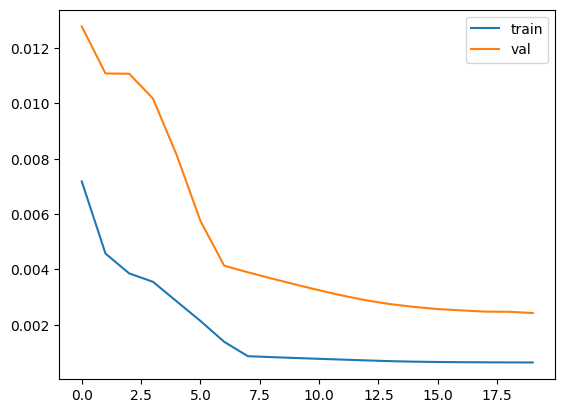

In [33]:
plt.plot(history["train"], label="train")
plt.plot(history["val"], label="val")
plt.legend()
plt.show()